In [1]:
import gpflow as gpf
import numpy as np 
import scipy
import matplotlib.pyplot as plt
from cpgp.segcpgp import SegCPGP as NormalSegCPGP
from cpgp.segcpgp_sparse import SegCPGP as FastSegCPGP
from cpgp.segcpgp_robust import SegCPGP as RobustSegCPGP
import json
import time

2025-05-20 09:52:50.543156: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 09:52:50.545786: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-20 09:52:50.574156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-20 09:52:50.574194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-20 09:52:50.575452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
def plot_result(X, y, segcpgp):
    plt.figure(figsize=(24, 3))
    plt.plot(X, y)
    for loc in segcpgp.LOCS:
        plt.axvline(loc, color="r")
        
    with open("/home/janneke/changepoint-gp/TCPD/annotations.json") as f:
        annot = json.load(f)
    for annotation in annot["well_log"]: 
        print(annot["well_log"], sorted(segcpgp.LOCS))
    plt.show()

In [3]:
def plot_model(model: gpf.models.GPModel) -> None:
    X, Y = model.data
    opt = gpf.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    gpf.utilities.print_summary(model, "notebook")

    Xplot = np.linspace(0.0, 200, 200)[:, None]

    y_mean, y_var = model.predict_y(Xplot, full_cov=False)
    y_lower = y_mean - 1.96 * np.sqrt(y_var)
    y_upper = y_mean + 1.96 * np.sqrt(y_var)

    _, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(X, Y, "kx", mew=2)
    (mean_line,) = ax.plot(Xplot, y_mean, "-")
    color = mean_line.get_color()
    ax.plot(Xplot, y_lower, lw=0.1, color=color)
    ax.plot(Xplot, y_upper, lw=0.1, color=color)
    ax.fill_between(
        Xplot[:, 0], y_lower[:, 0], y_upper[:, 0], color=color, alpha=0.1
    )

    # Also plot the inducing variables if possible:
    iv = getattr(model, "inducing_variable", None)
    if iv is not None:
        ax.scatter(iv.Z, np.zeros_like(iv.Z), marker="^")

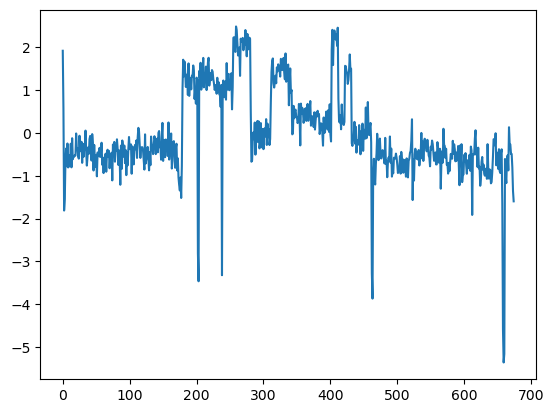

In [4]:
path = "/home/janneke/changepoint-gp/TCPD/datasets/well_log.json"

with open(path, 'r') as file:
    data = json.load(file)
X = np.array(data["time"]["index"])[:,None].astype(float)
y = np.array(data["series"][0]["raw"])[:,None]
y = (y - y.mean()) / y.std()
plt.plot(X, y)

0.0 674.0
p 8.016030632010772e-36 df 3 location [460.99015949] steepness [13.00530651]
0.0 454.0
p 1.100519717385358e-54 df 3 location [178.52310607] steepness [24.47507032]
0.0 172.0
p 0.43472161137314147 df 3 location [200.81379539] steepness [0.02204622]
183.0 454.0
p 6.4623722061543286e-09 df 3 location [280.50004549] steepness [26.10700007]
183.0 274.0
p 0.00037691030203341796 df 3 location [254.13417858] steepness [18.92747016]
183.0 248.0
p 1.0 df 3 location [171.22019351] steepness [1.25639718]
259.0 274.0
p 0.9998472047301682 df 3 location [270.67750308] steepness [0.00117357]
285.0 454.0
p 1.5032920460284118e-05 df 3 location [310.74269968] steepness [48.76267984]
285.0 304.0
p 0.9999999999959356 df 3 location [291.86140371] steepness [0.00066792]
315.0 454.0
p 1.8371028704180502e-07 df 3 location [431.54574277] steepness [30.48644445]
315.0 425.0
p 1.5807895669079868e-05 df 3 location [341.14231466] steepness [2.06253207]
315.0 335.0
p 0.025419197488886564 df 3 location [312

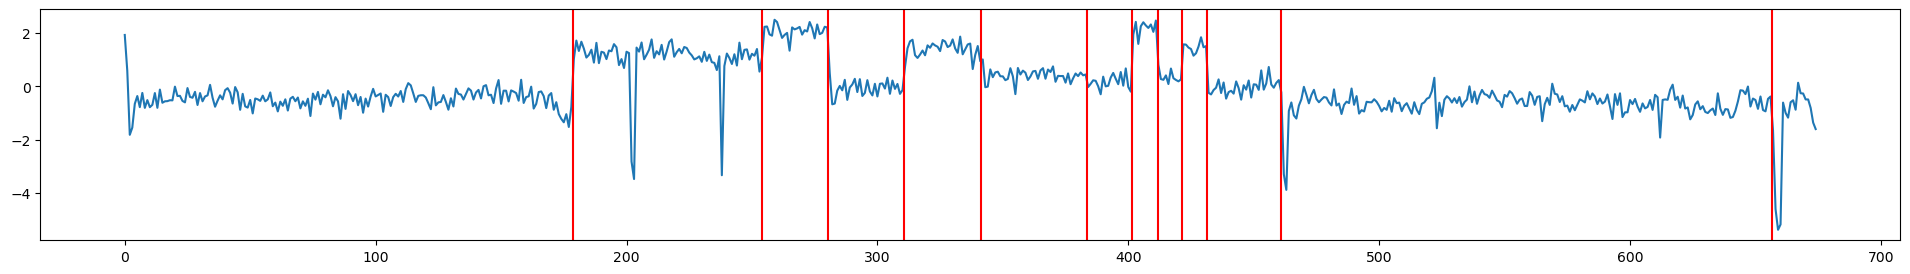

In [8]:
segcpgp = FastSegCPGP(n_ind=50)
dt = time.time()
segcpgp.fit(X, y, "constant")
print(time.time() - dt)
plot_result(X, y, segcpgp)

0.0 674.0
8.015869670880707e-36 3
p 8.015869670880707e-36 df 3 bic tf.Tensor(73.37662853507395, shape=(), dtype=float64) location [460.9911593] steepness [14.03974571]
0.0 454.0
1.1005004800333093e-54 3
p 1.1005004800333093e-54 df 3 bic tf.Tensor(117.60935183207509, shape=(), dtype=float64) location [178.53027285] steepness [28.43727278]
0.0 172.0
0.43472154060099844 3
p 0.43472154060099844 df 3 bic tf.Tensor(-6.3636548614654, shape=(), dtype=float64) location [200.81736024] steepness [0.02204427]
183.0 454.0
6.46234147018233e-09 3
p 6.46234147018233e-09 df 3 bic tf.Tensor(12.103402158405446, shape=(), dtype=float64) location [280.57636606] steepness [26.00549385]
183.0 274.0
0.0003769100082173215 3
p 0.0003769100082173215 df 3 bic tf.Tensor(2.3798398353263384, shape=(), dtype=float64) location [254.16868448] steepness [15.06875348]
183.0 248.0
1.0 3
p 1.0 df 3 bic tf.Tensor(-7.135396148757715, shape=(), dtype=float64) location [235.1920979] steepness [1.95541767]
259.0 274.0
0.7125624

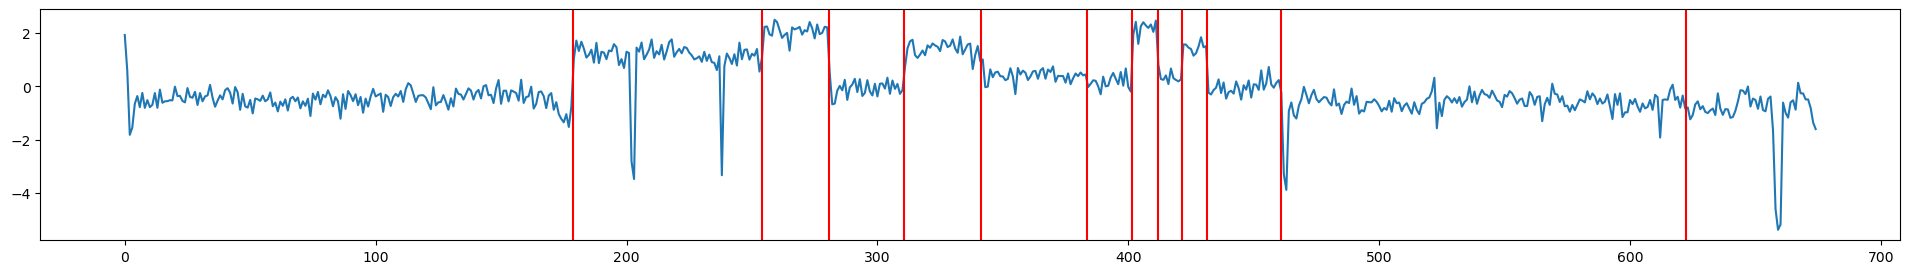

In [6]:
segcpgp = NormalSegCPGP()
dt = time.time()
segcpgp.fit(X, y, "constant")
print(time.time() - dt)
plot_result(X, y, segcpgp)

In [7]:
segcpgp = RobustSegCPGP()
dt = time.time()
segcpgp.fit(X, y, "constant")U
print(time.time() - dt)
plot_result(X, y, segcpgp)

SyntaxError: invalid syntax (579561060.py, line 3)

{'6': [179, 255, 281, 311, 343, 402, 413, 422, 432, 462, 464], '7': [179, 255, 281, 312, 343, 402, 412, 422, 432], '8': [179, 255, 282, 312, 343, 402, 413, 422, 432], '12': [177, 467], '13': [4, 179, 255, 281, 311, 344, 402, 412, 422, 432, 462, 464, 521, 526, 620, 643, 661]} [array([0.99918233]), array([177.11045451]), array([279.10522395]), array([306.00911589]), array([342.9217476]), array([352.99479195]), array([370.00283502]), array([399.00967432]), array([421.89682126]), array([436.90160014]), array([466.89215672]), array([621.91107678])]


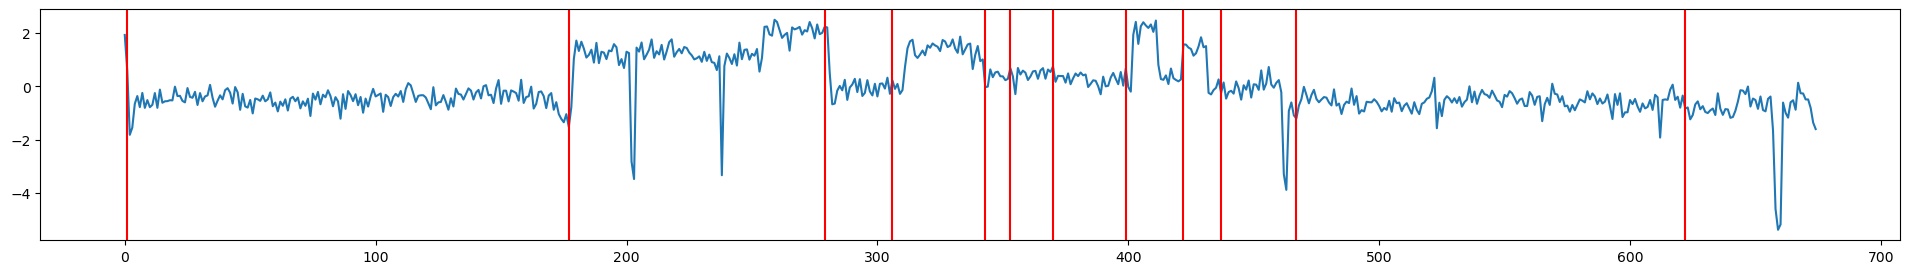

In [ ]:
plt.figure(figsize=(24, 3))
plt.plot(X, y)
for loc in segcpgp.LOCS:
    plt.axvline(loc, color="r")
    
with open("/home/janneke/changepoint-gp/TCPD/annotations.json") as f:
    annot = json.load(f)
print(annot["well_log"], sorted(segcpgp.LOCS))

NameError: name 'SegCPGP' is not defined

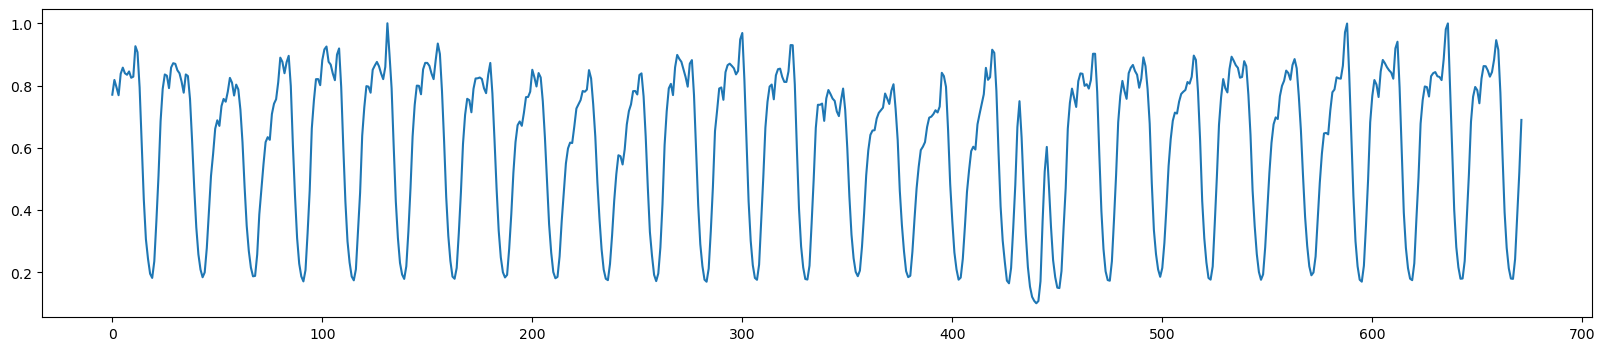

In [ ]:
path = "/home/janneke/Downloads/cloudflare-radar_get-http-timeseries_20250508.json"    

with open(path) as f:
    data = json.load(f)
    
X = data["result"]["main"]["timestamps"]
y = data["result"]["main"]["values"]
plt.figure(figsize=(20, 4))
X = np.arange(len(y)).astype(float).reshape(-1, 1)
y = np.array(y).astype(float).reshape(-1, 1)
plt.plot(y)

segcpgp = SegCPGP()
segcpgp.fit(X, y, "spectral-5")
for loc in segcpgp.LOCS:
    plt.axvline(loc, color="r")
plt.show()

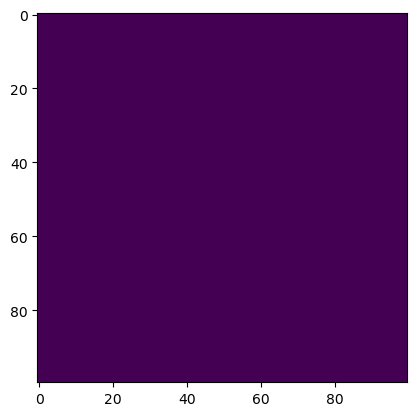

In [ ]:
k = gpf.kernels.Constant(1)
X = np.arange(0, 100).reshape(-1, 1)
plt.imshow(k(X))